# Forecasting Medicare Spending at the County level

Forecasting Medicare spending in 2014 using data from 2007 - 2012
https://github.com/brendan-drew/County-Medicare-Spending

## Hypothesis
How much do diabetics drive Medicare spending?

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

from src.import_raw_data import load_medicare_spending,load_pc_access

from IPython.display import display
pd.options.display.max_columns = None

In [2]:
#DataFrame with primary care access data from the Dartmouth Institute from 2003 - 2015 with a main focus on diabetics
#Only select 2008 to 2014 data for consistency purposes
pc = load_pc_access()
pc = pc.astype({'year':'int',})
pc = pc[(pc.year>2007) & (pc.year<2015)]

#Dataframe with detailed Medicare benificiary demographic/utilization
#Only select 2008 to 2014 data for consistency purposes
dfclean = pd.read_csv('data/medicare_county_level/cleaned_medicare_county_all.csv')
dfclean = dfclean.astype({'year':'int'})
dfclean = dfclean[dfclean.year>2007]

#DataFrame with Medicare Spending Data from the Dartmouth Institute from 2003-2015
#Only select 2008 to 2014 data for consistency purposes
mcspend = load_medicare_spending()
mcspend = mcspend.astype({'year':'int'})
mcspend = mcspend[(mcspend.year>2007) & (mcspend.year<2015)]

#Join the point of care and spend data for analysis
jn = pc.merge(mcspend.drop(columns =['medicare_enrollees','state','county_excl_state']),on=['county_id','county_name','year'],how='left')
jn = jn.apply(pd.to_numeric,errors='ignore')


#Remove racial destinction information and non-int data from joined dataframe
jns = jn[['county_id', 'medicare_enrollees',
       'rate_one_ambulatory_visit', 'diabetic_enrollees',
       'diabetic_pts_a1c', 'eye_exam', 'diabetic_pts_lipids', 'female_enrollees', 'beneficiaries_100_part_A',
       'leg_amputations', 'discharges_amb_sensitive', 'year', 'total_reimb',
       'total_reimb_price_adj', 'hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']]
logjns = jns.apply(np.log)

sm = pd.plotting.scatter_matrix(logjns,figsize=[20,20])
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

## Diabetics influence on Medicare spend
How much does diabetic population care drive total reimbursement? 

In [3]:
diab = jn[['county_id', 'medicare_enrollees',
       'black_medicare_enrollees', 'white_medicare_enrollees',
       'rate_one_ambulatory_visit', 'diabetic_enrollees',
       'black_diabetic_enrollees', 'white_diabetic_enrollees',
       'diabetic_pts_a1c', 'diabetic_pts_a1c_black',
       'diabetic_pts_a1c_white', 'eye_exam', 'eye_exam_black', 'eye_exam_white', 'diabetic_pts_lipids',
       'diabetic_pts_lipids_black', 'diabetic_pts_lipids_white', 'female_enrollees',
       'female_enrollees_black', 'female_enrollees_white', 'beneficiaries_100_part_A',
       'beneficiaries_100_part_A_black', 'beneficiaries_100_part_A_white',
       'leg_amputations', 'leg_amputations_black',
       'leg_amputations_white', 'discharges_amb_sensitive', 'discharges_amb_sensitive_black',
       'discharges_amb_sensitive_white','year', 'total_reimb',
       'total_reimb_price_adj', 'hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']]

In [4]:
len(diab)

21963

In [5]:
diab.isna().sum()

county_id                             0
medicare_enrollees                    9
black_medicare_enrollees          11210
white_medicare_enrollees           8526
rate_one_ambulatory_visit            21
diabetic_enrollees                  319
black_diabetic_enrollees          12598
white_diabetic_enrollees           6611
diabetic_pts_a1c                    319
diabetic_pts_a1c_black            12598
diabetic_pts_a1c_white             6611
eye_exam                            413
eye_exam_black                    13248
eye_exam_white                     7343
diabetic_pts_lipids                 381
diabetic_pts_lipids_black         12822
diabetic_pts_lipids_white          6893
female_enrollees                    647
female_enrollees_black            15450
female_enrollees_white             8306
beneficiaries_100_part_A              5
beneficiaries_100_part_A_black     4985
beneficiaries_100_part_A_white        5
leg_amputations                   19636
leg_amputations_black             21561


In [6]:
diabdrop = diab.dropna()

In [7]:
len(diabdrop)

382

In [8]:
recolumns = ['hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']

X = diabdrop.drop(columns=recolumns)

for col in recolumns:  
    Y = diabdrop[col]
    sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print("%.4f" % results.rsquared,"  :  ",col)

0.9977   :   hospital_snf_reimb
0.9975   :   hospital_snf_reimb_price_adj
0.9916   :   physician_reimb
0.9930   :   physician_reimb_price_adj
0.9659   :   outpatient_reimb
0.9636   :   outpatient_reimb_price_adj
0.9269   :   home_health_reimb
0.9282   :   home_health_reimb_price_adj
0.9393   :   hospice_reimb
0.9374   :   hospice_reimb_price_adj
0.9735   :   dme_reimb
0.9765   :   dme_reimb_price_adj


Text(0,0.5,'Studentized Residuals')

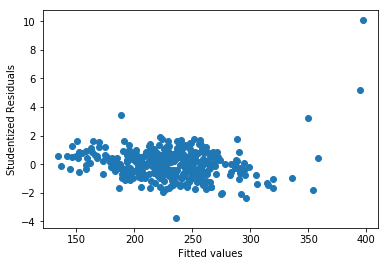

In [9]:
student_resid = results.outlier_test()['student_resid']
plt.scatter(results.fittedvalues, student_resid)
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

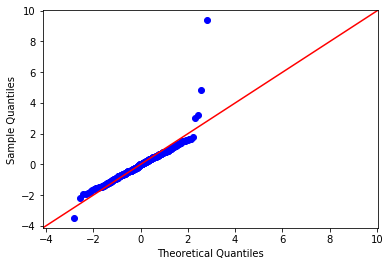

In [10]:
sm.graphics.qqplot(student_resid, line='45', fit=True)
plt.show()

In [11]:
linear = LinearRegression()

for col in recolumns:
    Y = diabdrop[col]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    # Fit your model using the training set
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate RMSE for training and test set
    print('Results for : ',col)
    print('MSE for training set ', mean_squared_error(y_train, train_predicted))
    print('MSE for test set ', mean_squared_error(y_test, test_predicted))
    print(' ')

Results for :  hospital_snf_reimb
MSE for training set  46417.799730390085
MSE for test set  140433.60565366247
 
Results for :  hospital_snf_reimb_price_adj
MSE for training set  52183.84194982132
MSE for test set  96631.16138416884
 
Results for :  physician_reimb
MSE for training set  69134.88999700006
MSE for test set  115195.21019503365
 
Results for :  physician_reimb_price_adj
MSE for training set  57740.718047861956
MSE for test set  100361.6671963138
 
Results for :  outpatient_reimb
MSE for training set  34375.81652821961
MSE for test set  46027.849876492786
 
Results for :  outpatient_reimb_price_adj
MSE for training set  33981.37687624549
MSE for test set  67450.69384220226
 
Results for :  home_health_reimb
MSE for training set  27078.385274933546
MSE for test set  84007.67106217192
 
Results for :  home_health_reimb_price_adj
MSE for training set  35331.67991047446
MSE for test set  619486.2639732332
 
Results for :  hospice_reimb
MSE for training set  8345.649515344538
M

### Log of X and Y values

In [12]:
logdiabdrop = diabdrop.apply(np.log)
logdiabdrop = logdiabdrop.dropna()

recolumns = ['hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']

logX = logdiabdrop.drop(columns=recolumns)
for col in recolumns:
    logY = logdiabdrop[col]
    sm.add_constant(logX)
    model = sm.OLS(logY,logX)
    results = model.fit()
    print("%.4f" % results.rsquared,"  :  ",col)

1.0000   :   hospital_snf_reimb
1.0000   :   hospital_snf_reimb_price_adj
1.0000   :   physician_reimb
1.0000   :   physician_reimb_price_adj
0.9997   :   outpatient_reimb
0.9997   :   outpatient_reimb_price_adj
0.9993   :   home_health_reimb
0.9994   :   home_health_reimb_price_adj
0.9988   :   hospice_reimb
0.9988   :   hospice_reimb_price_adj
0.9995   :   dme_reimb
0.9996   :   dme_reimb_price_adj


In [13]:
linear = LinearRegression()

for col in recolumns:
    logY = logdiabdrop[col]
    X_train, X_test, y_train, y_test = train_test_split(logX, logY, test_size=0.25)

    # Fit your model using the training set
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate RMSE for training and test set
    print('Results for : ',col)
    print('MSE for training set ', mean_squared_error(y_train, train_predicted))
    print('MSE for test set ', mean_squared_error(y_test, test_predicted))
    print('R2 Score ', r2_score(y_test, test_predicted))
    print(' ')

Results for :  hospital_snf_reimb
MSE for training set  0.0008777165427668852
MSE for test set  0.0014203459559486414
R2 Score  0.9590797160848575
 
Results for :  hospital_snf_reimb_price_adj
MSE for training set  0.0012785243178397034
MSE for test set  0.002150130676151285
R2 Score  0.8455355961813782
 
Results for :  physician_reimb
MSE for training set  0.002504553267722651
MSE for test set  0.00480755742705988
R2 Score  0.8752231719841552
 
Results for :  physician_reimb_price_adj
MSE for training set  0.002057307558347188
MSE for test set  0.008337221534886951
R2 Score  0.7330613818519758
 
Results for :  outpatient_reimb
MSE for training set  0.010128461544257974
MSE for test set  0.017147779450341124
R2 Score  0.584037327043762
 
Results for :  outpatient_reimb_price_adj
MSE for training set  0.011160035514958108
MSE for test set  0.01978377032185949
R2 Score  0.807420549000845
 
Results for :  home_health_reimb
MSE for training set  0.018152348080792552
MSE for test set  0.033

## Dropping less rows 

In [14]:
jn.isna().sum()

county_id                                      0
county_name                                    0
medicare_enrollees                             9
black_medicare_enrollees                   11210
white_medicare_enrollees                    8526
rate_one_ambulatory_visit                     21
lower_ci_one_amb_visit                        28
upper_ci_one_amb_visit                        28
rate_one_ambulatory_visit_black            11210
lower_ci_one_amb_visit_black               11217
upper_ci_one_amb_visit_black               11217
rate_one_ambulatory_visit_white             8526
lower_ci_one_amb_visit_white                8533
upper_ci_one_amb_visit_white                8533
diabetic_enrollees                           319
black_diabetic_enrollees                   12598
white_diabetic_enrollees                    6611
diabetic_pts_a1c                             319
lower_ci_diabetic_pts_a1c                    326
upper_ci_diabetic_pts_a1c                    326
diabetic_pts_a1c_bla

In [15]:
diab2 = jn[['county_id', 'medicare_enrollees',
       'rate_one_ambulatory_visit', 'diabetic_enrollees',
       'diabetic_pts_a1c', 'eye_exam', 'diabetic_pts_lipids', 'female_enrollees', 'beneficiaries_100_part_A', 'discharges_amb_sensitive','year', 'total_reimb',
       'total_reimb_price_adj', 'hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']]

In [16]:
diab2.isna().sum()

county_id                          0
medicare_enrollees                 9
rate_one_ambulatory_visit         21
diabetic_enrollees               319
diabetic_pts_a1c                 319
eye_exam                         413
diabetic_pts_lipids              381
female_enrollees                 647
beneficiaries_100_part_A           5
discharges_amb_sensitive         627
year                               0
total_reimb                     2435
total_reimb_price_adj           2435
hospital_snf_reimb              2435
hospital_snf_reimb_price_adj    2435
physician_reimb                 2435
physician_reimb_price_adj       2435
outpatient_reimb                2435
outpatient_reimb_price_adj      2435
home_health_reimb               2534
home_health_reimb_price_adj     2534
hospice_reimb                   4998
hospice_reimb_price_adj         4998
dme_reimb                       2435
dme_reimb_price_adj             2435
dtype: int64

In [17]:
diab2drop = diab2.dropna()

In [18]:
len(diab2drop)

16791

In [19]:
recolumns = ['hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']

X = diab2drop.drop(columns=recolumns)

for col in recolumns:  
    Y = diab2drop[col]
    sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print("%.4f" % results.rsquared,"  :  ",col)

0.9934   :   hospital_snf_reimb
0.9937   :   hospital_snf_reimb_price_adj
0.9699   :   physician_reimb
0.9738   :   physician_reimb_price_adj
0.9194   :   outpatient_reimb
0.9150   :   outpatient_reimb_price_adj
0.8209   :   home_health_reimb
0.8198   :   home_health_reimb_price_adj
0.8080   :   hospice_reimb
0.8001   :   hospice_reimb_price_adj
0.9556   :   dme_reimb
0.9537   :   dme_reimb_price_adj


In [20]:
linear = LinearRegression()

for col in recolumns:
    Y = diab2drop[col]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    # Fit your model using the training set
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate RMSE for training and test set
    print('Results for : ',col)
    print('MSE for training set ', mean_squared_error(y_train, train_predicted))
    print('MSE for test set ', mean_squared_error(y_test, test_predicted))
    print(' ')

Results for :  hospital_snf_reimb
MSE for training set  113031.5194064997
MSE for test set  113899.85861643594
 
Results for :  hospital_snf_reimb_price_adj
MSE for training set  113546.07051706545
MSE for test set  143870.34601396404
 
Results for :  physician_reimb
MSE for training set  151239.02536980683
MSE for test set  253429.71119741327
 
Results for :  physician_reimb_price_adj
MSE for training set  140610.74627188896
MSE for test set  274389.5168095504
 
Results for :  outpatient_reimb
MSE for training set  140803.829046468
MSE for test set  144926.7734547878
 
Results for :  outpatient_reimb_price_adj
MSE for training set  165252.9857987048
MSE for test set  166232.1223844307
 
Results for :  home_health_reimb
MSE for training set  68066.80542990695
MSE for test set  89542.50485865973
 
Results for :  home_health_reimb_price_adj
MSE for training set  75690.14943189756
MSE for test set  91849.25138067236
 
Results for :  hospice_reimb
MSE for training set  30553.507523365464
M

### Log of X and Y of new drop

In [21]:
logdiab2drop = diab2drop.apply(np.log)
logdiab2drop = logdiab2drop.dropna()
len(logdiab2drop)

16752

In [22]:
recolumns = ['hospital_snf_reimb',
       'hospital_snf_reimb_price_adj', 'physician_reimb',
       'physician_reimb_price_adj', 'outpatient_reimb',
       'outpatient_reimb_price_adj', 'home_health_reimb',
       'home_health_reimb_price_adj', 'hospice_reimb',
       'hospice_reimb_price_adj', 'dme_reimb', 'dme_reimb_price_adj']

logX = logdiab2drop.drop(columns=recolumns)
for col in recolumns:
    logY = logdiab2drop[col]
    sm.add_constant(logX)
    model = sm.OLS(logY,logX)
    results = model.fit()
    print("%.4f" % results.rsquared,"  :  ",col)

0.9999   :   hospital_snf_reimb
0.9999   :   hospital_snf_reimb_price_adj
0.9996   :   physician_reimb
0.9997   :   physician_reimb_price_adj
0.9988   :   outpatient_reimb
0.9988   :   outpatient_reimb_price_adj
0.9937   :   home_health_reimb
0.9938   :   home_health_reimb_price_adj
0.9916   :   hospice_reimb
0.9916   :   hospice_reimb_price_adj
0.9985   :   dme_reimb
0.9985   :   dme_reimb_price_adj


In [23]:
linear = LinearRegression()

for col in recolumns:
    logY = logdiab2drop[col]
    X_train, X_test, y_train, y_test = train_test_split(logX, logY, test_size=0.25)

    # Fit your model using the training set
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    # Calculate MSE for training and test set
    print('Results for : ',col)
    print('MSE for training set ', mean_squared_error(y_train, train_predicted))
    print('MSE for test set ', mean_squared_error(y_test, test_predicted))
    print('R2 Score ', r2_score(y_test, test_predicted))
    print(' ')

Results for :  hospital_snf_reimb
MSE for training set  0.005728363185607544
MSE for test set  0.005668947192929402
R2 Score  0.8211259843438179
 
Results for :  hospital_snf_reimb_price_adj
MSE for training set  0.005281199263174
MSE for test set  0.005503803869911899
R2 Score  0.8573850792701236
 
Results for :  physician_reimb
MSE for training set  0.02233614812204493
MSE for test set  0.02157924972657459
R2 Score  0.5993211408419505
 
Results for :  physician_reimb_price_adj
MSE for training set  0.019575135641846264
MSE for test set  0.02074308331278274
R2 Score  0.6086949100930428
 
Results for :  outpatient_reimb
MSE for training set  0.04372060594788093
MSE for test set  0.04402187272021064
R2 Score  0.5227590859060196
 
Results for :  outpatient_reimb_price_adj
MSE for training set  0.04655621737987497
MSE for test set  0.04617495627297644
R2 Score  0.5283242758035396
 
Results for :  home_health_reimb
MSE for training set  0.21922523683539064
MSE for test set  0.2210059587941

Text(0,0.5,'y_predicted')

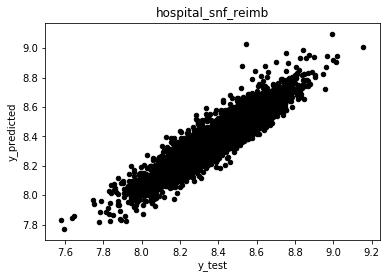

In [24]:
linear = LinearRegression()

logY = logdiab2drop['hospital_snf_reimb_price_adj']
X_train, X_test, y_train, y_test = train_test_split(logX, logY, test_size=0.25)

# Fit your model using the training set
linear.fit(X_train, y_train)

# Call predict to get the predicted values for training and test set
train_predicted = linear.predict(X_train)
test_predicted = linear.predict(X_test)

plt.scatter(y_test,test_predicted, color='k', s=20)
plt.title('hospital_snf_reimb')
plt.xlabel('y_test')
plt.ylabel('y_predicted')

### Reducing Training Data
Making training data smaller and should reduce statistical values to help validate lack of data linkage 

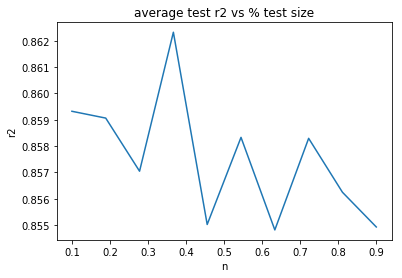

In [25]:
linear = LinearRegression()
r2scores=[]
logY = logdiab2drop['hospital_snf_reimb_price_adj']

for i in np.linspace(0.1,0.9,10):
    X_train, X_test, y_train, y_test = train_test_split(logX, logY, test_size=i)

    # Fit your model using the training set
    linear.fit(X_train, y_train)

    # Call predict to get the predicted values for training and test set
    train_predicted = linear.predict(X_train)
    test_predicted = linear.predict(X_test)

    r2scores.append(r2_score(y_test, test_predicted))
    
plt.plot(np.linspace(0.1,0.9,10),r2scores)
plt.xlabel('n')
plt.ylabel('r2')
plt.title('average test r2 vs % test size');

### K-Fold Cross Validation

In [26]:
def my_cross_val_score(X_data, y_data, num_folds=3):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=num_folds)
    error = np.empty(num_folds)
    index = 0
    linear = LinearRegression()
    for train, test in kf.split(X_data):
        linear.fit(X_data.iloc[train], y_data.iloc[train])
        pred = linear.predict(X_data.iloc[test])
        error[index] = mean_squared_error(pred, y_data.iloc[test])
        index += 1
    return np.mean(error)

In [27]:
# Varying number of k-folds
cv_scores = []
for k in range(2,51):
    cv_score = my_cross_val_score(logX, logY, num_folds=k)
    cv_scores.append(cv_score)

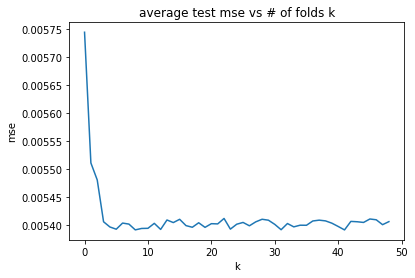

In [28]:
plt.plot(cv_scores)
plt.xlabel('k')
plt.ylabel('mse')
plt.title('average test mse vs # of folds k');

### Feature Engineering
Making the model more accurate

In [55]:
#Get coeficient values at each K fold
def my_coef(X_data, y_data, num_folds=3):
    df = pd.DataFrame(columns = list(X_data.columns))
    kf = KFold(n_splits=num_folds)
    index = 0
    linear = LinearRegression()
    for train, test in kf.split(X_data):
        linear.fit(X_data.iloc[train], y_data.iloc[train])
        df=df.append(pd.Series(list(linear.coef_), index=df.columns), ignore_index=True)
        index += 1
    return df

In [60]:
# Varying number of k-folds
cfdf = pd.DataFrame(columns = list(logX.columns))
for k in range(5,51):
    cf = my_coef(logX, logY, num_folds=k)
    cfdf = pd.concat([cfdf, cf], ignore_index=True)

In [68]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(cfdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=cfdf.index, columns=cfdf.columns)

In [71]:
cfdf.shape

(1265, 13)

In [72]:
scaled_features_df.shape

(1265, 13)

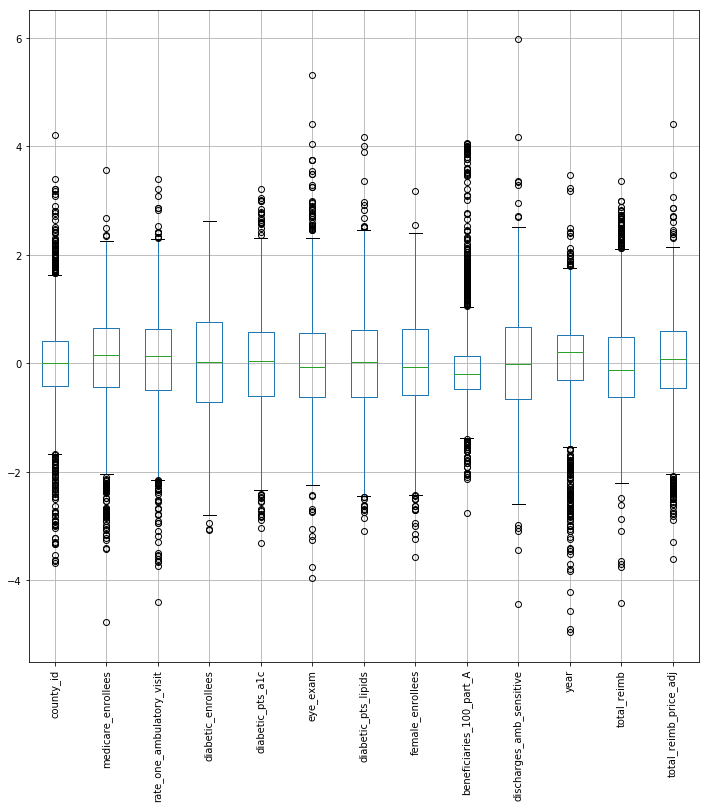

In [75]:
scaled_features_df.boxplot(figsize=(12,12),rot=90)

### New Data Online

### Uncontrolled Diabetes 
How does a uncontrolled diabetic population effect medicare?